In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.cluster import KMeans
from pandas.tseries.offsets import DateOffset

import math

import matplotlib.cm as cm
from matplotlib.collections import LineCollection

sns.set()

In [2]:
# To display all columns when needed
pd.set_option('display.max_columns', None)

# Fuction to add infos about the type and null values to .describe function


def df_description(df):
    # General description
    description = df.describe(include='all', datetime_is_numeric=True)

    # Types and content of the columns
    description_type = pd.DataFrame(df.dtypes, columns=['type']).T
    number_null = (df.shape[0] - description.loc['count'].T)
    percent_null = (df.shape[0] - description.loc['count'].T)*100/df.shape[0]
    description_null = pd.DataFrame([number_null, percent_null],
                                    index=['number null', 'percentage null'])

    # Concatenate general, type and null stats
    description = pd.concat([description_type, description_null, description])
    return description

In [3]:
# Read the datasets
cust_df = pd.read_csv('cust_uniq_df_tsne_clusters.csv',
                      sep='\t', low_memory=False)
orders_df = pd.read_csv('orders_data.csv',
                        sep='\t', low_memory=False)

Sending the cluster labels for each customer unique id to orders_data.

In [4]:
print('The size of the orders_dataset before merging:', orders_df.shape)
orders_df = pd.merge(orders_df,
                     cust_df[['customer_unique_id',
                              'K-means_labels_RFM_RS_tsne']],
                     on='customer_unique_id',
                     how='left')
print('The size of the orders_dataset after merging:', orders_df.shape)

The size of the orders_dataset before merging: (95569, 20)
The size of the orders_dataset after merging: (95569, 21)


In [5]:
df_description(orders_df)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,time_since_order,nbr_items,tot_price,tot_freight_value,review_score,tot_payment_value,delivery_time(h),dummy_col,K-means_labels_RFM_RS_tsne
type,object,object,object,object,object,object,object,object,object,int64,object,object,float64,float64,float64,float64,int64,float64,float64,int64,int64
number null,0.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percentage null,0.0,0.0,0.0,0.0,0.014649,0.001046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,95569,95569,95569,95569,95555,95568,95569,95569,95569,95569.0,95569,95569,95569.0,95569.0,95569.0,95569.0,95569.0,95569.0,95569.0,95569.0,95569.0
unique,95569,95569,1,95048,87498,79403,94771,444,92506,NaN,4065,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-07-28 13:11:22,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20,1b6c7548a2a1f9037c1fd3ddfed95f33,NaN,sao paulo,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,95569,3,9,47,3,504,7,NaN,14955,40243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35129.440049,NaN,NaN,6931.873829,1.13158,125.158104,21.905553,4.146648,147.063658,300.245781,1.0,2.839477
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29839.290415,NaN,NaN,3667.638284,0.481822,140.41439,16.450276,1.292435,147.85762,228.490456,0.0,1.168574
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.0,NaN,NaN,1178.0,1.0,0.85,0.0,1.0,9.59,12.0,1.0,0.0


Transforming order_purchase_timestamp to datetime type

In [6]:
orders_df['order_purchase_timestamp'] = orders_df['order_purchase_timestamp']\
                                        .apply(pd.to_datetime)

In [7]:
# Number of orders per year
orders_df.groupby(orders_df['order_purchase_timestamp'].dt.year).size()

order_purchase_timestamp
2016      264
2017    43030
2018    52275
dtype: int64

In [8]:
# Number of orders per quarter
orders_df.groupby([orders_df['order_purchase_timestamp'].dt.year,
                   orders_df['order_purchase_timestamp'].dt.quarter]).size()

order_purchase_timestamp  order_purchase_timestamp
2016                      4                             264
2017                      1                            4902
                          2                            8909
                          3                           12113
                          4                           17106
2018                      1                           20476
                          2                           19424
                          3                           12375
dtype: int64

In [9]:
# Number of orders monthly
orders_df.groupby([orders_df['order_purchase_timestamp'].dt.year,
                   orders_df['order_purchase_timestamp'].dt.quarter,
                   orders_df['order_purchase_timestamp'].dt.month]).size()

order_purchase_timestamp  order_purchase_timestamp  order_purchase_timestamp
2016                      4                         10                           263
                                                    12                             1
2017                      1                         1                            743
                                                    2                           1636
                                                    3                           2523
                          2                         4                           2281
                                                    5                           3520
                                                    6                           3108
                          3                         7                           3849
                                                    8                           4171
                                                    9                    

Operations:
- Training k-means (k=5) clustering on an initial periode of the first 14 months to generate clusters
- Recalculate the clusters adding one month each time
- Calculate the Adjusted Rand Score between the two training, making sure to compare the same\
customers (those of the intial periode of the first 14 months)
- Repetition of the operation 4 time by shifting the initial time by two months

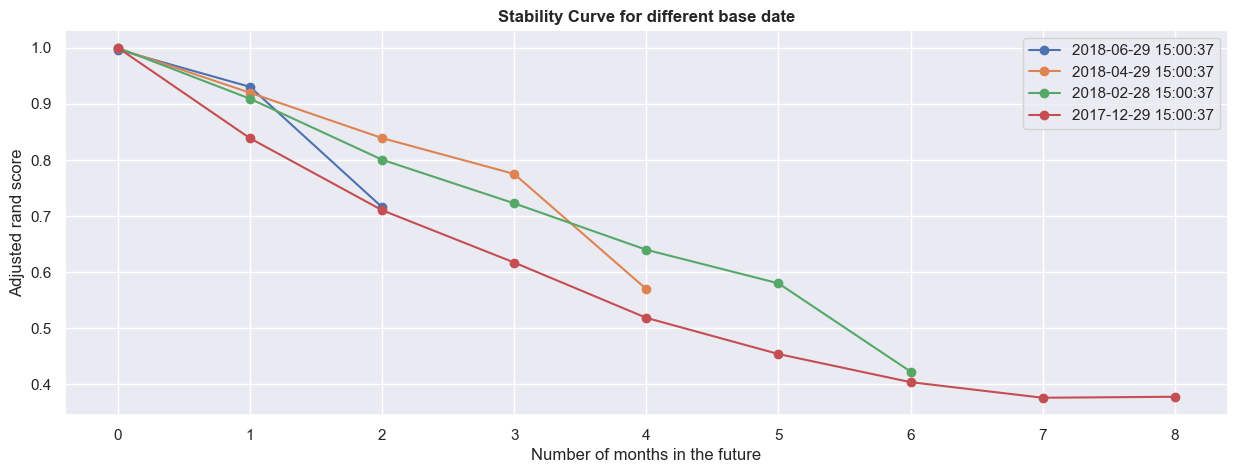

In [10]:
plt.figure(figsize=(15, 5))

for i in np.arange(2, 9, 2):
    dateLastOrder_init = (orders_df['order_purchase_timestamp'].max()
                          - DateOffset(months=i))

    # Selection of data
    X = orders_df[orders_df['order_purchase_timestamp'] < dateLastOrder_init]

    # Feature engineering
    X_FE = X.groupby('customer_unique_id')\
            .agg(nbr_orders=('dummy_col', 'sum'),
                 time_since_last_order_h=('time_since_order', 'min'),
                 sum_tot_payment_value=('tot_payment_value', 'sum'),
                 review_score=('review_score', 'mean'))
    # Creating order_id column
    X_FE['customer_unique_id'] = X_FE.index
    # Resetting the index of the created dataset
    X_FE = X_FE.reset_index(drop=True)
    # Rounding mean_review_score
    X_FE['review_score'] = X_FE['review_score'].round()
    # Creating mean_payment_value column
    X_FE['payment_value'] = (X_FE['sum_tot_payment_value']
                             / X_FE['nbr_orders'])

    # Standardize the features
    col_list = ['nbr_orders', 'time_since_last_order_h',
                'payment_value', 'review_score']
    X_FE_norm = pd.DataFrame(StandardScaler().fit_transform(X_FE[col_list]))
    X_FE_norm.columns = col_list
    X_FE_norm['customer_unique_id'] = X_FE['customer_unique_id']

    # K-means clustering on RFM + review score features using 5 clusters
    clusterer_init = KMeans(n_clusters=5,
                            init='k-means++',
                            n_init=10).fit(X_FE_norm[col_list])
    cluster_labels = clusterer_init.predict(X_FE_norm[col_list])
    X_FE_norm['labels'] = cluster_labels

    ARS = []
    for j in range(0, i+1):
        dateLastOrder = (orders_df['order_purchase_timestamp'].max()
                         - DateOffset(months=(i-j)))

        # Selection of data
        X_ITF = orders_df[orders_df['order_purchase_timestamp']
                          < dateLastOrder]

        # Feature engineering
        X_ITF_FE = X_ITF\
            .groupby('customer_unique_id')\
            .agg(nbr_orders=('dummy_col', 'sum'),
                 time_since_last_order_h=('time_since_order', 'min'),
                 sum_tot_payment_value=('tot_payment_value', 'sum'),
                 review_score=('review_score', 'mean'))
        # Creating order_id column
        X_ITF_FE['customer_unique_id'] = X_ITF_FE.index
        # Resetting the index of the created dataset
        X_ITF_FE = X_ITF_FE.reset_index(drop=True)
        # Rounding mean_review_score
        X_ITF_FE['review_score'] = X_ITF_FE['review_score'].round()
        # Creating mean_payment_value column
        X_ITF_FE['payment_value'] = (X_ITF_FE['sum_tot_payment_value']
                                     / X_ITF_FE['nbr_orders'])

        # Standardize the features
        col_list = ['nbr_orders', 'time_since_last_order_h',
                    'payment_value', 'review_score']
        X_ITF_FE_norm = pd.DataFrame(StandardScaler()
                                     .fit_transform(X_ITF_FE[col_list]))
        X_ITF_FE_norm.columns = col_list
        X_ITF_FE_norm['customer_unique_id'] = X_ITF_FE['customer_unique_id']

        # K-means clustering on RFM + review score features using 5 clusters
        clusterer = KMeans(n_clusters=5,
                           init='k-means++',
                           n_init=10).fit(X_ITF_FE_norm[col_list])
        cluster_labels = clusterer.predict(X_ITF_FE_norm[col_list])
        X_ITF_FE_norm['labels_ITF'] = cluster_labels

        Comp_df = pd.merge(X_FE_norm[['customer_unique_id', 'labels']],
                           X_ITF_FE_norm[['customer_unique_id', 'labels_ITF']],
                           on='customer_unique_id',
                           how='left')

        # Comparaison between 'labels_true' and 'labels_pred'
        score = adjusted_rand_score(Comp_df['labels'],
                                    Comp_df['labels_ITF'])
        ARS.append((dateLastOrder, j, score))

    ARS = pd.DataFrame(ARS, columns=['dateLastOrder',
                                     'number_of_months',
                                     'adjusted_rand_score'])

    # Plotting the stability plot
    plt.plot(ARS['number_of_months'],
             ARS['adjusted_rand_score'],
             marker='o',
             label=dateLastOrder_init)
    plt.title('Stability Curve for different base date',
              fontsize=12,
              fontweight='bold')
    plt.ylabel('Adjusted rand score')
    plt.xlabel('Number of months in the future')

plt.legend()
plt.show()

Observations:

We see that the ARS score got below 0.8 after 1.5 months.\
K-Means need to be run again in 1 month and a half to genertae new cluster labels for the customers.

We see as well that the more customers we have in the database, the more stable the cluster labels\
(higher ARI score for the newest initial date).\
This means that the more customers in the database,\
the longer is the time needed for the up to date of the clusters.

Advise form the evaluator, better to use this method to get the stability of the model:\
Operations:
- (1) Training k-means (k=5) clustering on an initial periode of the first 14 months to generate clusters
- (2) Recalculate the clusters adding one month each time
- (3) Predict the clusters of the new period using the fit of the initial period (of the 14 months)
- (4) Calculate the Adjusted Rand Score between the two training (point 2 vs 3)
- (5) Repetition of the operation 4 time by shifting the initial time by two months

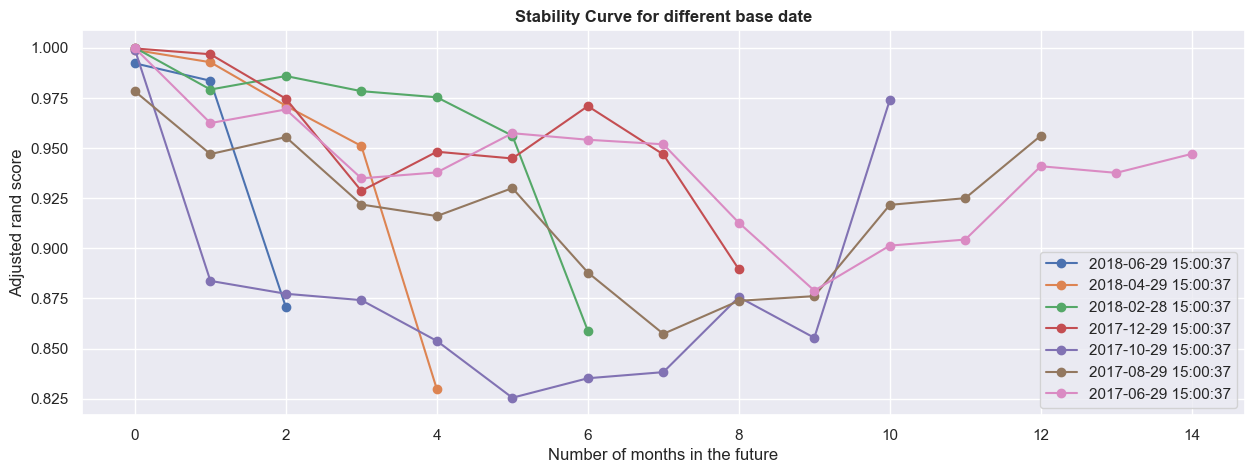

In [13]:
plt.figure(figsize=(15, 5))

for i in np.arange(2, 15, 2):
    dateLastOrder_init = (orders_df['order_purchase_timestamp'].max()
                          - DateOffset(months=i))

    # Selection of data
    X = orders_df[orders_df['order_purchase_timestamp'] < dateLastOrder_init]

    # Feature engineering
    X_FE = X.groupby('customer_unique_id')\
            .agg(nbr_orders=('dummy_col', 'sum'),
                 time_since_last_order_h=('time_since_order', 'min'),
                 sum_tot_payment_value=('tot_payment_value', 'sum'),
                 review_score=('review_score', 'mean'))
    # Creating order_id column
    X_FE['customer_unique_id'] = X_FE.index
    # Resetting the index of the created dataset
    X_FE = X_FE.reset_index(drop=True)
    # Rounding mean_review_score
    X_FE['review_score'] = X_FE['review_score'].round()
    # Creating mean_payment_value column
    X_FE['payment_value'] = (X_FE['sum_tot_payment_value']
                             / X_FE['nbr_orders'])

    # Standardize the features
    col_list = ['nbr_orders', 'time_since_last_order_h',
                'payment_value', 'review_score']
    X_FE_norm = pd.DataFrame(StandardScaler().fit_transform(X_FE[col_list]))
    X_FE_norm.columns = col_list
    X_FE_norm['customer_unique_id'] = X_FE['customer_unique_id']

    # K-means clustering on RFM + review score features using 5 clusters
    clusterer_init = KMeans(n_clusters=5,
                            init='k-means++',
                            n_init=10).fit(X_FE_norm[col_list])
    #cluster_labels = clusterer_init.predict(X_FE_norm[col_list])
    #X_FE_norm['labels'] = cluster_labels

    ARS = []
    for j in range(0, i+1):
        dateLastOrder = (orders_df['order_purchase_timestamp'].max()
                         - DateOffset(months=(i-j)))

        # Selection of data
        X_ITF = orders_df[orders_df['order_purchase_timestamp']
                          < dateLastOrder]

        # Feature engineering
        X_ITF_FE = X_ITF\
            .groupby('customer_unique_id')\
            .agg(nbr_orders=('dummy_col', 'sum'),
                 time_since_last_order_h=('time_since_order', 'min'),
                 sum_tot_payment_value=('tot_payment_value', 'sum'),
                 review_score=('review_score', 'mean'))
        # Creating order_id column
        X_ITF_FE['customer_unique_id'] = X_ITF_FE.index
        # Resetting the index of the created dataset
        X_ITF_FE = X_ITF_FE.reset_index(drop=True)
        # Rounding mean_review_score
        X_ITF_FE['review_score'] = X_ITF_FE['review_score'].round()
        # Creating mean_payment_value column
        X_ITF_FE['payment_value'] = (X_ITF_FE['sum_tot_payment_value']
                                     / X_ITF_FE['nbr_orders'])

        # Standardize the features
        col_list = ['nbr_orders', 'time_since_last_order_h',
                    'payment_value', 'review_score']
        X_ITF_FE_norm = pd.DataFrame(StandardScaler()
                                     .fit_transform(X_ITF_FE[col_list]))
        X_ITF_FE_norm.columns = col_list
        X_ITF_FE_norm['customer_unique_id'] = X_ITF_FE['customer_unique_id']

        # K-means clustering on RFM + review score features using 5 clusters
        clusterer = KMeans(n_clusters=5,
                           init='k-means++',
                           n_init=10).fit(X_ITF_FE_norm[col_list])
        cluster_labels = clusterer.predict(X_ITF_FE_norm[col_list])
        X_ITF_FE_norm['labels_ITF'] = cluster_labels
        
        cluster_labels = clusterer_init.predict(X_ITF_FE_norm[col_list])
        X_ITF_FE_norm['labels_init'] = cluster_labels

        #Comp_df = pd.merge(X_FE_norm[['customer_unique_id', 'labels']],
        #                   X_ITF_FE_norm[['customer_unique_id', 'labels_ITF']],
        #                   on='customer_unique_id',
        #                   how='left')

        # Comparaison between 'labels_true' and 'labels_pred'
        score = adjusted_rand_score(X_ITF_FE_norm['labels_init'],
                                    X_ITF_FE_norm['labels_ITF'])
        ARS.append((dateLastOrder, j, score))

    ARS = pd.DataFrame(ARS, columns=['dateLastOrder',
                                     'number_of_months',
                                     'adjusted_rand_score'])

    # Plotting the stability plot
    plt.plot(ARS['number_of_months'],
             ARS['adjusted_rand_score'],
             marker='o',
             label=dateLastOrder_init)
    plt.title('Stability Curve for different base date',
              fontsize=12,
              fontweight='bold')
    plt.ylabel('Adjusted rand score')
    plt.xlabel('Number of months in the future')

plt.legend()
plt.show()